# **Загрузка** **Датасета**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kuznetsovvaleksandr","key":"cc6a303a6f39337760716ed143c02062"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ishikajohari/best-books-10k-multi-genre-data

best-books-10k-multi-genre-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip best-books-10k-multi-genre-data.zip

Archive:  best-books-10k-multi-genre-data.zip
replace goodreads_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls

 best-books-10k-multi-genre-data.zip   drive		   'kaggle (1).json'   sample_data
 data.csv			       goodreads_data.csv   kaggle.json


In [ ]:
!pip install sentence_transformers

# **Обработка данных**

In [ ]:
import csv
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer

from sentence_transformers import SentenceTransformer, util


import nltk
import string
import re
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

Создание датафрейма

In [ ]:
df = pd.read_csv('/content/goodreads_data.csv')

In [ ]:
df.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


Привел жанры в нормальный вид

In [ ]:
df['Genres'] = df['Genres'].apply(lambda x: x.lower())
df['Genres'] = df['Genres'].str.replace(',', '')
df['Genres'] = df['Genres'].str.replace(' ', '_')
df['Genres'] = df['Genres'].str.replace("'_", " ")
df['Genres'] = df['Genres'].str.replace("'", '')
df['Genres'] = df['Genres'].str.replace('[', '')
df['Genres'] = df['Genres'].str.replace(']', '')
df.head()

<ipython-input-154-31ab5eb9b13c>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Genres'] = df['Genres'].str.replace('[', '')
<ipython-input-154-31ab5eb9b13c>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Genres'] = df['Genres'].str.replace(']', '')


,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,classics fiction historical_fiction school lit...,4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,fantasy fiction young_adult magic childrens mi...,4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...",classics fiction romance historical_fiction li...,4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,classics nonfiction history biography memoir h...,4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,classics fiction dystopia fantasy politics sch...,3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


Удаление пропусков, так как нет возможности для восстановления

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   10000 non-null  int64  
 1   Book         10000 non-null  object 
 2   Author       10000 non-null  object 
 3   Description  9923 non-null   object 
 4   Genres       10000 non-null  object 
 5   Avg_Rating   10000 non-null  float64
 6   Num_Ratings  10000 non-null  object 
 7   URL          10000 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


In [ ]:
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9923 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   9923 non-null   int64  
 1   Book         9923 non-null   object 
 2   Author       9923 non-null   object 
 3   Description  9923 non-null   object 
 4   Genres       9923 non-null   object 
 5   Avg_Rating   9923 non-null   float64
 6   Num_Ratings  9923 non-null   object 
 7   URL          9923 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 697.7+ KB


Приведение описания в нормальный вид

In [ ]:
nltk.download('punkt')

nltk.download('popular')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading 

True

In [ ]:
%%time
def clean_text(txt):
    """""
    очистка данных
    1- Замена сокращений
    2- Удаление знаков препинания
    3- Разбиение на слова
    4- Удаление стоп-слов
    5- Удаление оставшихся знаков препинания
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # Замена сокращений
    txt = replace_contractions(txt)

    #Удаление знаков препинания
    txt  = "".join([char for char in txt if char not in string.punctuation])
    txt = re.sub('[0-9]+', '', txt)

    # Разбиение на слова
    words = word_tokenize(txt)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    # Удаление оставшихся знаков препинания
    words = [word for word in words if word.isalpha()]

    cleaned_text = ' '.join(words)
    return cleaned_text

df['Description'] = df['Description'].apply(lambda txt: clean_text(txt))

CPU times: user 16.8 s, sys: 476 ms, total: 17.2 s
Wall time: 31 s


In [ ]:
df['Description'] = df.Description.str.lower()

In [ ]:
df.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,the unforgettable novel childhood sleepy south...,classics fiction historical_fiction school lit...,4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,harry potter thinks ordinary boy rescued owl t...,fantasy fiction young_adult magic childrens mi...,4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,since immediate success pride prejudice remain...,classics fiction romance historical_fiction li...,4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,discovered attic spent last years life anne fr...,classics nonfiction history biography memoir h...,4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,librarians note there alternate cover edition ...,classics fiction dystopia fantasy politics sch...,3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


In [ ]:
#Сброс индекса для цикла, так как чистили данные

df.reset_index(drop= True , inplace= True )

Лемматизация

In [ ]:
#Лемматизация

from textblob import TextBlob, Word

for i in range(len(df)):
  lem = TextBlob(df['Description'][i])
  lemmatized_sentence = " ".join([w.lemmatize() for w in lem.words])
  df['Description'][i] = lemmatized_sentence
df.head()

<ipython-input-163-01fe0af00966>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description'][i] = lemmatized_sentence


,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,the unforgettable novel childhood sleepy south...,classics fiction historical_fiction school lit...,4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,harry potter think ordinary boy rescued owl ta...,fantasy fiction young_adult magic childrens mi...,4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,since immediate success pride prejudice remain...,classics fiction romance historical_fiction li...,4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,discovered attic spent last year life anne fra...,classics nonfiction history biography memoir h...,4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,librarian note there alternate cover edition e...,classics fiction dystopia fantasy politics sch...,3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


Создание столбца, который включает в себя автора, описание и жанры

In [ ]:
features = ['Author', 'Description', 'Genres']

In [ ]:
def combine_features(row):
 return row['Author']+' '+row['Description']+' '+row['Genres']

In [ ]:
for feature in features:
    df[feature] = df[feature].fillna('')
df['combined_features'] = df.apply(combine_features,axis=1)

In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['Avg_Rating'], axis=1)
df = df.drop(['Num_Ratings'], axis=1)
df = df.drop(['URL'], axis=1)
df = df.drop(['Author'], axis=1)
df = df.drop(['Description'], axis=1)
df = df.drop(['Genres'], axis=1)
df.head()

,Book,combined_features
0,To Kill a Mockingbird,Harper Lee the unforgettable novel childhood s...
1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling harry potter think ordinary boy r...
2,Pride and Prejudice,Jane Austen since immediate success pride prej...
3,The Diary of a Young Girl,Anne Frank discovered attic spent last year li...
4,Animal Farm,George Orwell librarian note there alternate c...


# **Тема для поиска**

Создание дополнительной строки.
В нее я включу тему, по которой буду искать литературу

In [ ]:
df = df.append(pd.Series(), ignore_index=True)
df.iloc[-1]

<ipython-input-168-0083d90ce34b>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df = df.append(pd.Series(), ignore_index=True)
<ipython-input-168-0083d90ce34b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.Series(), ignore_index=True)


Book                 NaN
combined_features    NaN
Name: 9923, dtype: object

Необходимо ввести тему на АНГЛИЙСКОМ языке.

Столбцы с названием книги и объединенный столбец в последней строке называю темой

In [ ]:
#Поле для ввода темы для поиска

theme = 'data science and machine learning'

df['combined_features'].iloc[-1], df['Book'].iloc[-1] = theme, theme

df.reset_index(drop= True , inplace= True )

In [ ]:
book_name = theme
k = 20

In [ ]:
df

,Book,combined_features
0,To Kill a Mockingbird,Harper Lee the unforgettable novel childhood s...
1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling harry potter think ordinary boy r...
2,Pride and Prejudice,Jane Austen since immediate success pride prej...
3,The Diary of a Young Girl,Anne Frank discovered attic spent last year li...
4,Animal Farm,George Orwell librarian note there alternate c...
...,...,...
9919,Dynamo,Eleanor Gustafson jeth cavanaugh searching new...
9920,The Republic of Trees,Sam Taylor this dark fable tell story four eng...
9921,"Waking Up (Healing Hearts, #1)",Renee Dyer for adriana monroe life get better ...
9922,Bits and Pieces: Tales and Sonnets,Jas T. Ward after demand thousand fan various ...


# **CountVectorizer**

In [ ]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df['combined_features'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix)

In [ ]:
def get_title_from_index(index):
    return df[df.index == index]['Book'].values[0]
def get_index_from_title(Book):
    return df[df.Book == Book]['Unnamed: 0'].values[0]

In [ ]:
book_index = df[df['Book'] == book_name].index[0]

similar_book = list(enumerate(cosine_sim[int(book_index)]))

sorted_similar_book = sorted(similar_book,key=lambda x:x[1],reverse=True)

i=0
for element in sorted_similar_book:
		print(get_title_from_index(element[0]), sorted_similar_book[i][1])
		i=i+1
		if i>k:
			break

data science and machine learning 0.9999999999999999
The Great Action: Comic Book for Yuppies 0.2189522206015893
Make It Stick: The Science of Successful Learning 0.20464687117164015
Leonardo da Vinci 0.19920476822239894
Physics of the Impossible 0.19547111097008837
The Great Action (Super Indy, #4) 0.19104017997521755
Bad Science 0.18257418583505536
Cosmos 0.18090680674665816
THE YOGA WITH NO PANTS: Super Indy-The Last Half 0.1765469659009499
Imitating Humans: A Technical Approach 0.1746667529218746
The Brain that Changes Itself: Stories of Personal Triumph from the Frontiers of Brain Science 0.1676003807884977
Where the Conflict Really Lies: Science, Religion, and Naturalism 0.16483267673842683
Invisible Women: Data Bias in a World Designed for Men 0.16467739391852365
The Secret of Childhood 0.1632993161855452
The Disappearing Spoon: And Other True Tales of Madness, Love, and the History of the World from the Periodic Table of the Elements 0.16064386578049977
God, the Evolver: A Secu

# **TFIDFvectorizer**

In [ ]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

In [ ]:
cosine_sim_2 = cosine_similarity(tfidf_matrix)

In [ ]:
book_index_2 = df[df['Book'] == book_name].index[0]

similar_book_2 = list(enumerate(cosine_sim_2[int(book_index_2)]))

sorted_similar_book_2 = sorted(similar_book_2,key=lambda x:x[1],reverse=True)

i=0
for element in sorted_similar_book_2:
		print(get_title_from_index(element[0]), sorted_similar_book_2[i][1])
		i=i+1
		if i>k:
			break

data science and machine learning 1.0
Make It Stick: The Science of Successful Learning 0.18628081221948367
White: The Great Pursuit (The Circle, #3) 0.16580870872946468
Back To You 0.1657140424196335
Get Your Self Scam Free 0.16411391329331126
Invisible Women: Data Bias in a World Designed for Men 0.1598822392052073
Imitating Humans: A Technical Approach 0.1538413948937552
Everybody Lies: Big Data, New Data, and What the Internet Can Tell Us About Who We Really Are 0.1486066279827474
Leonardo da Vinci 0.1360598067579155
The Time Machine 0.12782464140899683
The Brain that Changes Itself: Stories of Personal Triumph from the Frontiers of Brain Science 0.12752207859811676
Domechild 0.12355592312230734
Bajki robotów 0.11965958048501253
Physics of the Impossible 0.1185307880814305
The Machine Stops 0.11840176482618667
The Undoing Project: A Friendship That Changed Our Minds 0.10940533086084263
The Secret of Childhood 0.108247555305264
The Fifth Discipline: The Art & Practice of The Learnin

# **SentenceTransformer**

In [ ]:
sentence = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
embeddings1 = sentence.encode(df['combined_features'].iloc[0])

embeddings2 = sentence.encode(df['combined_features'].iloc[1])

In [ ]:
#Проверка работоспособности

cos_sim = util.cos_sim(embeddings1, embeddings2)
print("Cosine-Similarity:", cos_sim)

Cosine-Similarity: tensor([[0.2938]])


In [ ]:



book_description_genres = list()

for i in range(df.shape[0]):
    #print(i)
    book_description_genres.append(df['combined_features'].iloc[i])

book_description_genres = book_description_genres[:-1]

embeddings = sentence.encode(book_description_genres)


def rec_sys(book_theme, n):

  df['combined_features'].iloc[-1], df['Book'].iloc[-1] = book_theme, book_theme

  df.reset_index(drop= True , inplace= True )


  def emb(embed):
    embedding = list(embed)
    embedding_theme = sentence.encode(df['combined_features'].iloc[-1])
    embedding_theme = list(embedding_theme)
    embedding.append(embedding_theme)
    embedding = np.array(embedding)
    return embedding

  embedding = emb(embeddings)
  cos_sim = util.cos_sim(embedding, embedding)

  def get_recommendations(book_id, similarity_matrix):
      similar_books = list(enumerate(similarity_matrix[book_id]))
      similar_books = sorted(similar_books, key=lambda x: x[1], reverse=True)
      similar_books = similar_books[1:n+1]
      recommended_books = [df.iloc[i[0]]["Book"] for i in similar_books]
      return recommended_books


  book_id = df[df['Book'] == book_theme].index[0]
  similar = list(enumerate(cos_sim[book_id]))
  similar = sorted(similar, key=lambda x: x[1], reverse=True)
  similar = similar[0:n+1]
  recommended_books = get_recommendations(book_id, cos_sim)

  rec_list = list([] for i in range(n))

  print('Тема для поиска', book_theme)
  for i in range(len(recommended_books)):
    rec_list[i].append(float(similar[i+1][1]))
    rec_list[i].append(recommended_books[i])

  return rec_list


In [ ]:
k = 20
my_theme = book_name

rec_list = rec_sys(my_theme, k)
col_list = ['COS_SIM', 'BOOK']
rec_df = pd.DataFrame(data=rec_list, columns=col_list)


rec_df

Тема для поиска data science and machine learning


,COS_SIM,BOOK
0,0.339796,The Future of Artificial Intelligence in Digit...
1,0.326669,Power And Prediction: The Disruptive Economics...
2,0.301802,Swarm
3,0.290570,When: The Scientific Secrets of Perfect Timing
4,0.289164,Imitating Humans: A Technical Approach
5,0.288899,Invisible Women: Data Bias in a World Designed...
6,0.280811,"Avogadro Corp (Singularity, #1)"
7,0.279732,How the World Really Works: A Scientist's Guid...
8,0.278329,The Double Helix
9,0.268697,Fooled by Randomness: The Hidden Role of Chanc...


# **Сравнение моделей**

In [ ]:
lin_1 = list([] for i in range(2))
lin_2 = list([] for i in range(2))
lin_3 = list([] for i in range(2))

lin_1[0] = list(i for i in range(20))
lin_2[0] = list(i for i in range(20))
lin_3[0] = list(i for i in range(20))

for i in range(1, 21):
  lin_1[1].append(sorted_similar_book[i][1])
  lin_2[1].append(sorted_similar_book_2[i][1])
  lin_3[1].append(float(rec_list[i - 1][0]))

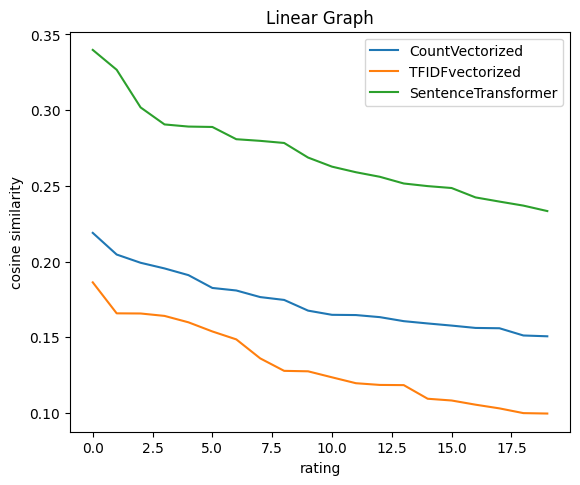

In [ ]:
fig = plt.figure(figsize = (5, 4))

ax = fig.add_axes([1, 1, 1, 1])

ax1 = ax.plot(lin_1[0], lin_1[1])
ax2 = ax.plot(lin_2[0], lin_2[1])
ax3 = ax.plot(lin_3[0], lin_3[1])

ax.set_title("Linear Graph")

ax.set_ylabel("cosine similarity")
ax.set_xlabel("rating")

ax.legend(labels = ('CountVectorized', 'TFIDFvectorized', 'SentenceTransformer'))

plt.show()

При любом раскладе, SenceTransformer справляется лучше

In [ ]:
cos_sim_list = list([] for i in range(k))

In [ ]:
for i in range(k):
  cos_sim_list[i].append(sorted_similar_book[i + 1][1])
  cos_sim_list[i].append(sorted_similar_book_2[i + 1][1])
  cos_sim_list[i].append(float(rec_list[i][0]))

In [ ]:
col_list = ['CountVectorized', 'TFIDFvectorized', 'SentenceTransformer']

In [ ]:
cos_sim_df = pd.DataFrame(columns=col_list, data=cos_sim_list)
cos_sim_df

,CountVectorized,TFIDFvectorized,SentenceTransformer
0,0.218952,0.186281,0.339797
1,0.204647,0.165809,0.326669
2,0.199205,0.165714,0.301802
3,0.195471,0.164114,0.290570
4,0.191040,0.159882,0.289164
5,0.182574,0.153841,0.288899
6,0.180907,0.148607,0.280811
7,0.176547,0.136060,0.279732
8,0.174667,0.127825,0.278329
9,0.167600,0.127522,0.268697


# **Итог**

In [ ]:
print('Введите кол-во книг, которые хотите получить')
k = int(input())
print('Введите тему, которая вам интересна')
my_theme = input()

rec_list = rec_sys(my_theme, k)
col_list = ['COS_SIM', 'BOOK']
rec_df = pd.DataFrame(data=rec_list, columns=col_list)


rec_df

Введите кол-во книг, которые хотите получить
20
Введите тему, которая вам интересна
lovecraft
Тема для поиска lovecraft


,COS_SIM,BOOK
0,0.663078,The Call of Cthulhu
1,0.659653,At the Mountains of Madness
2,0.601137,Necronomicon: The Best Weird Tales
3,0.569750,The Best of H.P. Lovecraft: Bloodcurdling Tale...
4,0.533788,The Call of Cthulhu and Other Weird Stories
5,0.454393,The Shadow over Innsmouth
6,0.438251,The Complete Works of H.P. Lovecraft
7,0.410062,"The Golden Sword (Silistra, #2)"
8,0.408186,The Sacred Band
9,0.394858,The Elfstones of Shannara (The Original Shann...


# **Сохранение**

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
df.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

In [ ]:
np.savetxt("embeddings.csv", embeddings, delimiter=",")